In [5]:
import pandas as pd
import numpy as np
import cv2
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import pickle
import cloudpickle
import numpy as np
import pybase64
pd.set_option('display.max_rows', 5000)
from fuzzywuzzy import fuzz
import imutils
from imutils import contours
import matplotlib.pyplot as plt
import os
import math
import imutils, cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Base class which will contains the methods for Shape detection
class ShapeFinder(BaseEstimator, TransformerMixin):
      
    #constructor
    def __init__(self,checkbox = True, radio_bt = True,rec_max_area = 6000,rec_min_area = 300,blocksize = 19,
                                                thresh_const = 3,epsilon = .065,aspect_ratio = (.85,1.2),kernelsize = (3,3),
                                                hough_param1 = 30,hough_param2 = 25):
        
        
        #initialize class variables
        self.rec_max_area = rec_max_area
        self.rec_min_area = rec_min_area
        self.blocksize = blocksize 
        self.thresh_const = thresh_const
        self.epsilon = epsilon
        self.kernelsize = kernelsize
        self.checkbox = checkbox
        self.radio_bt = radio_bt
        self.aspect_ratio = aspect_ratio
        self.extracted_img_data = []
        self.hough_param1 = hough_param1
        self.hough_param2 = hough_param2      
                       
    
    #decode base64 encoded images
    def decode_images(self,input_imgs):
    
        image_arr = []
        
        try:        
            #decode the images
            for img_file in (input_imgs):

                #decode base64
                img_file = pybase64.b64decode(img_file)

                #convert the bytearray to image
                nparr = np.frombuffer(img_file, np.uint8)            
                img = cv2.imdecode(nparr,cv2.IMREAD_COLOR)
                image_arr.append(img)
        
        except Exception as e:            
            print('The following exception occured during decoding the input image(s): ',e) 
        
        return image_arr
    
                   
    #read the image(s) and store in an array
    def get_shapes(self,input_imgs):
        
        image_arr = []
        
        #get decoded images
        image_arr = self.decode_images(input_imgs)

        if self.radio_bt == True:
            self.extract_circles(image_arr)        

        if self.checkbox == True:
            self.extract_quads(image_arr)
                   
        
        return self.extracted_img_data
    
    #image processing for quadrilateral shapes
    def do_quad_imageprocessing(self,gray,block_size,tc,kernelsize):
        
        try:
            #thresholding
            th2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,block_size,tc) 

            #remove background
            fgbg = cv2.createBackgroundSubtractorMOG2()
            fgmask = fgbg.apply(th2)
            thresh2 = cv2.adaptiveThreshold(fgmask,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,block_size,tc)

            #image dilation
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelsize[0],kernelsize[1]))
            img_dilate = cv2.dilate(thresh2.copy(), kernel,iterations = 1)        
        
        except Exception as e:
            print('The following exception occured during image preprocessing: ',e)
            img_dilate = []

        return img_dilate  
     
    #detect circles
    def extract_circles(self,image_arr):
               
        #loop through each image    
        for orig_img in (image_arr):            
            
            extracted_circles = []
            img = orig_img.copy()
            
            try:
                #grayscale only if its not already
                if len(img.shape) > 2: 
                    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
                else:
                    gray = img.copy()

                height,width = np.array(gray).shape
                mask = np.zeros((height,width), np.uint8)

                #used bilateral but other blurring methods can also be explored
                blur_img = cv2.bilateralFilter(gray,15,42,61) 
                detected_circles = cv2.HoughCircles(blur_img, cv2.HOUGH_GRADIENT, 1, 20, param1 = self.hough_param1 , param2 = self.hough_param2, minRadius = 1, maxRadius = 40) 

                # Draw circles that are detected. 
                if detected_circles is not None: 

                    # Convert the circle parameters a, b and r to integers. 
                    detected_circles = np.uint16(np.around(detected_circles)) 

                    for pt in detected_circles[0, :]: 
                        a, b, r = pt[0], pt[1], pt[2] 
                        area = (math.pi*r*r)

                        if area > 100:
                            # Draw the circumference of the circle. 
                            cv2.circle(img, (a, b), r, (0,255, 0), 2) 
                            circle_img = cv2.circle(mask,(a,b),r,(255,255,255),thickness=-1)      

                    # Copy the image using that mask
                    masked_data = cv2.bitwise_and(orig_img, orig_img, mask=mask)

                    # Apply Threshold
                    _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)

                    # Find Contour
                    contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
                    contours = imutils.grab_contours(contours)

                    for c in contours:
                        peri = cv2.arcLength(c, True)
                        approx = cv2.approxPolyDP(c, (.055)* peri, True)

                        #bounding rec cordinates
                        (x, y, w, h) = cv2.boundingRect(approx)

                        # Crop masked_data
                        crop = masked_data[y:y+h,x:x+w]
                        resized_roi = cv2.resize(crop, (32,32), interpolation = cv2.INTER_LINEAR)

                        #save the extracted radio buttons/circles
                        extracted_circles.append(resized_roi)
                        
            except Exception as e:
                print('The following exception occured during circle shape detection: ',e)

            #save the original image with highlighted circles in the same folder 
            self.extracted_img_data.append([img,extracted_circles])
                                           
           
    #detect checkbox/square
    def extract_quads(self,image_arr):
                     
        if len(image_arr) > 0:
        
            for original_image in (image_arr):
                
                #to store extracted images
                image = original_image.copy()          

                #grayscale only if its not already
                if len(image.shape) > 2:
                    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)  
                else:
                    gray = image.copy()

                #image preprocessing for quadrilaterals
                img_dilate = self.do_quad_imageprocessing(gray,self.blocksize,self.thresh_const,self.kernelsize)   

                if len(img_dilate) > 0:

                    try:
                        #detect contours
                        cnts = cv2.findContours(img_dilate.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                        cnts = imutils.grab_contours(cnts)
                        extracted_quad = []
                        
                        #loop through detected contours
                        for c in cnts:
                            peri = cv2.arcLength(c, True)
                            approx = cv2.approxPolyDP(c, (self.epsilon)* peri, True)

                            #bounding rec cordinates
                            (x, y, w, h) = cv2.boundingRect(approx)

                            #get the aspect ratio
                            aspectratio = float(w/h)
                            area = cv2.contourArea(c) 
                            if area < self.rec_max_area and area > self.rec_min_area and (aspectratio >= self.aspect_ratio[0] and aspectratio <= self.aspect_ratio[1]):

                                #check if there are 4 corners in the polygon
                                if len(approx) == 4:                 
                                    cv2.drawContours(original_image,[c], 0, (0,255,0), 2)
                                    roi = original_image[y:y+h, x:x+w]
                                    resized_roi = cv2.resize(roi, (32,32), interpolation = cv2.INTER_LINEAR)
                                    extracted_quad.append(resized_roi)

                    except Exception as e:
                        print('The following exception occured during quad shape detection: ',e)
                        
                self.extracted_img_data.append((original_image,extracted_quad))
        
        else:            
            print('No image is found during the extraction process')
            
        
    #override the transform and fit method from the base class
    def transform(self, input_imgs):
       
        extracted_shapes = self.get_shapes(input_imgs)

        return (extracted_shapes,self.checkbox,self.radio_bt)


    def fit(self):

        return self
            
               

In [7]:
class ShapeDetector(BaseEstimator, TransformerMixin):
   
    def __init__(self, checkbox_model=None,radioBT_model = None):
        self.checkbox_model = checkbox_model
        self.radioBT_model = radioBT_model
      
    def predict(self,data):
        
        extracted_shapes,checkbox,radio_bt = data

        probabilities = []
        images = []
        image_arr = []
        
        predicted_data = []
                
        for x in extracted_shapes:
            for index,y in enumerate(x):
                if index == 0:
                    pass
                else:
                    for z in y:
                        if len(z.shape) > 2:
                            z = cv2.cvtColor(z,cv2.COLOR_BGR2GRAY)
                        z = z.reshape((z.shape)+(1,))
                        images.append(z)        
               
        
        for index,probabs in enumerate(self.checkbox_model.predict_proba(np.array(images))):
            probabilities.append(probabs[1])
            image_arr.append(np.array(images[index]).reshape(32,32))
            
        return [probabilities,image_arr]
    
    def fit(self, data):

        return self

In [8]:
from keras.models import load_model
 
# load model
checkbox_model = load_model('checkbox_keras_model_v1.h5')
radioBt_model = load_model('radioBt_keras_model_v1.h5')

input_imgs = []

#generate pipeline
pipeline = Pipeline(steps = [('Shape Finder', ShapeFinder(checkbox = True, radio_bt = False,rec_max_area = 6000,rec_min_area = 300,blocksize = 19,
                                                thresh_const = 3,epsilon = .065,aspect_ratio = (.85,1.2),kernelsize = (3,3),
                                                hough_param1 = 30,hough_param2 = 25)),
                                 ('Shape Detection', ShapeDetector(checkbox_model,radioBt_model))])


## Testing the pipeline

In [9]:
def input_data_simulator(dirname):
    
    encoded_image_arr = []
    image_shape_arr = []
    
    #get the jpegs array and the shape array
    for x in os.listdir(dirname):      
        
        #get the jpegs
        if (x.split('.')[1]) == 'jpg':
                img_filename = x
                b = open(os.path.join(dirname,img_filename), "rb").read()
                encoded_image = pybase64.b64encode(b)
                encoded_image_arr.append(encoded_image)
                              
    return encoded_image_arr

dirname = 'Checkbox Testing'
input_imgs = input_data_simulator(dirname)

predicted_data = (pipeline.predict(input_imgs))

## Beautification of the output !

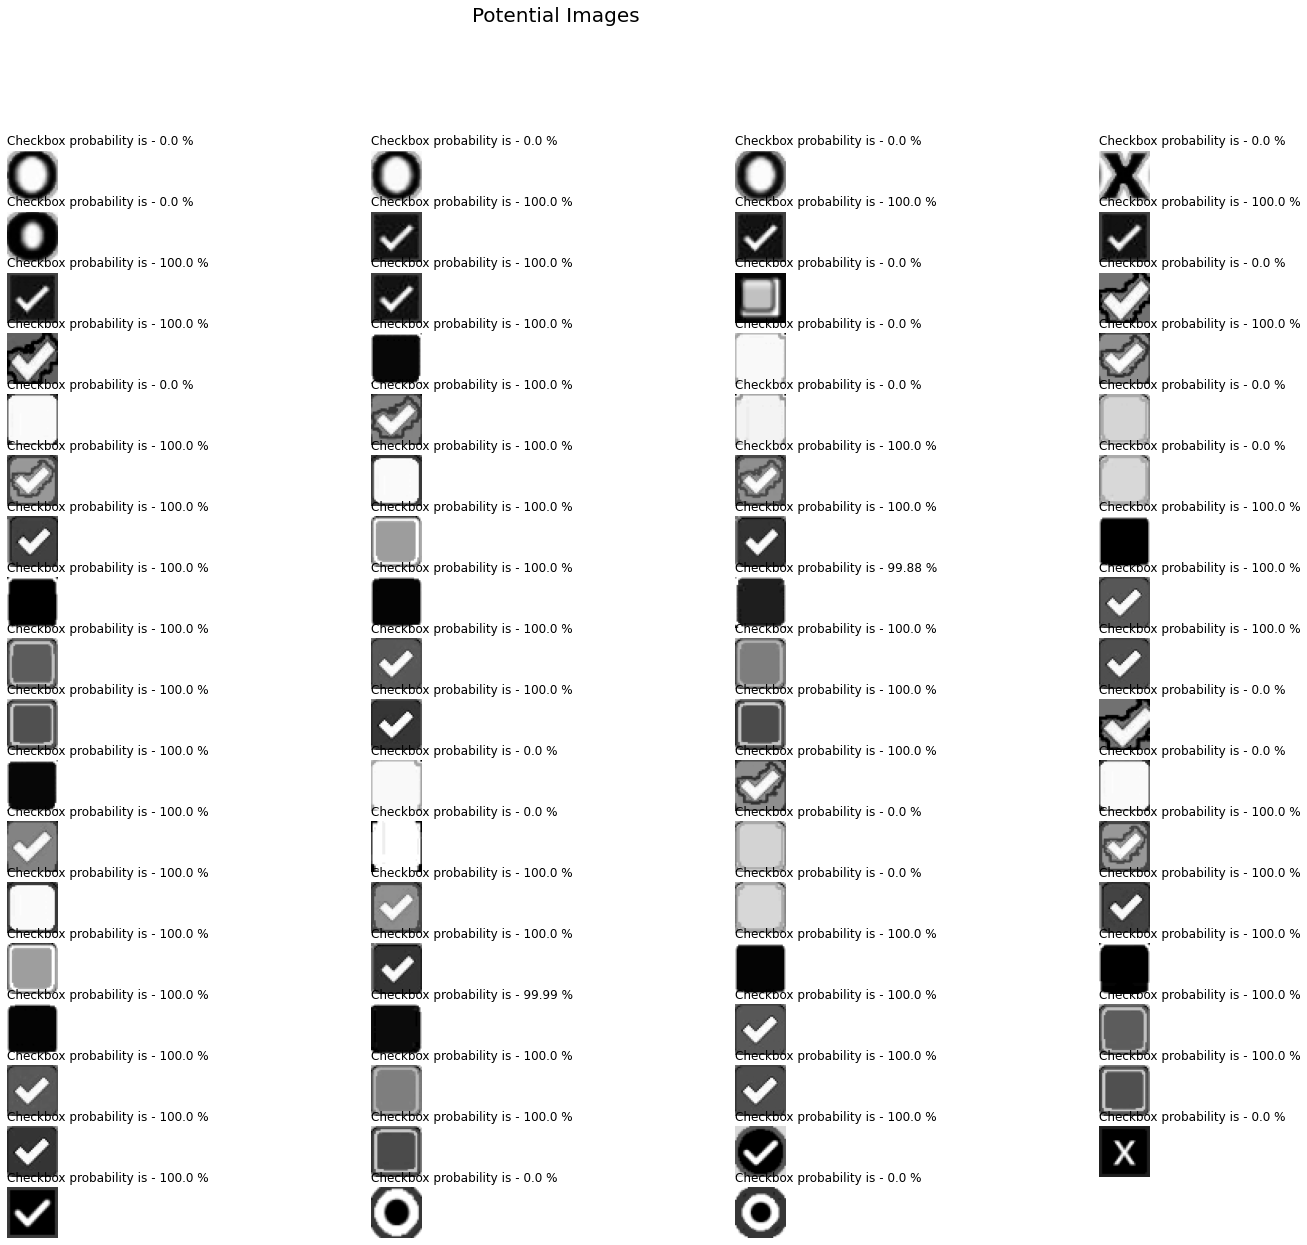

In [10]:

rows = math.ceil(len(predicted_data[1])/4)

fig,ax = plt.subplots(nrows=rows, ncols=4,figsize = (25,20),sharex=True)
#[axi.set_axis_off() for axi in ax.ravel()]
count = 0
fig.suptitle('Potential Images',fontsize = 20)

if rows > 1:
    for i in range(rows):
        for j in range(4): 
            if count < len(predicted_data[0]):  
                index = str(np.round(np.squeeze(predicted_data[0][count])*100,2))
                title = 'Checkbox probability is - ' + '' +(index) + ' %'
                ax[i,j].imshow(predicted_data[1][count],cmap = 'gray')
                ax[i,j].set_title(title,loc = 'left')
                ax[i, j].set_frame_on(False)
                count += 1
            ax[i,j].set_axis_off()  
else:
    
    for i in range(rows):       
        if count < len(predicted_data[0]):  
            index = str(np.round(np.squeeze(predicted_data[0][count])*100,2))
            title = 'Checkbox probability is - ' + '' +(index) + ' %'
            ax[i].imshow(predicted_data[1][count],cmap = 'gray')
            ax[i].set_title(title,loc = 'left')
            ax[i].set_frame_on(False)
            count += 1
        ax[i].set_axis_off()  
        
plt.show()